# STEP 1

#### Import Libraries

In [278]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import math
import geojson
import numpy as np
from openpyxl import load_workbook


#### Create the Medium Voltage net

In [279]:
net = nw.create_cigre_network_mv(with_der=False)
#Check Net Content
net

This pandapower network includes the following parameter tables:
   - bus (15 elements)
   - load (18 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (2 elements)
   - bus_geodata (15 elements)

## 1.1 State of the Network

What is the state of the network? Check bus voltage [pu] and line/transformer loading [%]

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, and the maximum line loading is 100%.

Set the limits for Voltage Per Unit (pu) and for Line loading

### Limit Parameters

In [280]:
bus_max_pu=1.1
bus_min_pu=0.9
max_line_loading=100
max_trafo_loading=100

### Run the net and plot

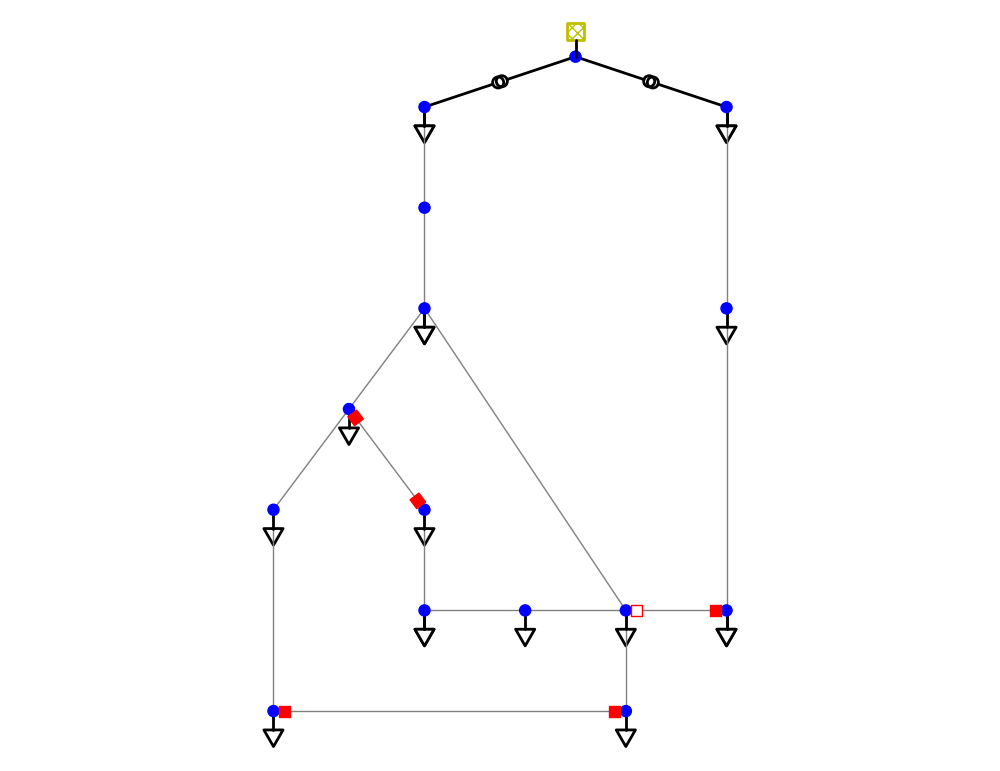

         name  bus      p_mw    q_mvar  const_z_percent  const_i_percent   
0     Load R1    1  14.99400  3.044662              0.0              0.0  \
1     Load R3    3   0.27645  0.069285              0.0              0.0   
2     Load R4    4   0.43165  0.108182              0.0              0.0   
3     Load R5    5   0.72750  0.182329              0.0              0.0   
4     Load R6    6   0.54805  0.137354              0.0              0.0   
5     Load R8    8   0.58685  0.147078              0.0              0.0   
6    Load R10   10   0.47530  0.119121              0.0              0.0   
7    Load R11   11   0.32980  0.082656              0.0              0.0   
8    Load R12   12  14.99400  3.044662              0.0              0.0   
9    Load R14   14   0.20855  0.052268              0.0              0.0   
10   Load CI1    1   4.84500  1.592474              0.0              0.0   
11   Load CI3    3   0.22525  0.139597              0.0              0.0   
12   Load CI

In [289]:
pp.runpp(net)
plot.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0, 
                 plot_loads=True, plot_gens=False, plot_sgens=False, 
                 load_size=2, gen_size=1.0, sgen_size=1.0, 
                 switch_size=2.0, switch_distance=1.0, plot_line_switches=True, scale_size=True, 
                 bus_color='b', line_color='grey', trafo_color='k', ext_grid_color='y', switch_color='r', library='igraph', show_plot=True, ax=None)

print(net.load)

### Define the Plotting Function with Color map

In [282]:


def plot_colormaps(line_values,bus_values,trafo_values,load_values,file_name):
    
    line_values=net.res_line.loading_percent
    bus_values=net.res_bus.vm_pu
    trafo_values=net.res_trafo.loading_percent
    load_values=net.res_load.p_mw
    switch_values=net.res_switch.i_ka


    cmap_list_line=[(0, "#00e33e"),(50, "yellow"),  (max_line_loading, "red")]
    cmap_list_bus=[(bus_min_pu, "#00e33e"),(1,"yellow"), (bus_max_pu, "red")]
    cmap_list_trafo=[((0, 80), "#00e33e"), ((80, max_trafo_loading), "yellow"), ((max_trafo_loading, 200), "red")]
    cmap_list_load=[(0, "red"), (0.1, "#00e33e")]
    #cmap_list_switch=[((0,0.0001),"red"),((0.0001,100),"blue")]

    cmap_line, norm_line = plot.cmap_continuous(cmap_list_line)
    cmap_bus, norm_bus= plot.cmap_continuous(cmap_list_bus)
    cmap_trafo, norm_trafo =plot.cmap_discrete(cmap_list_trafo)
    cmap_load, norm_load = plot.cmap_continuous(cmap_list_load)
    #cmap_switch, norm_switch = plot.cmap_discrete(cmap_list_switch)

    load_colors=cmap_load(norm_load(load_values))
    #switch_colors=cmap_switch(norm_switch(switch_values))


    line_c = plot.create_line_collection(net, net.line.index, z=line_values, zorder=1, cmap=cmap_line, norm=norm_line, linewidths=2)
    bus_c = plot.create_bus_collection(net, net.bus.index, z=bus_values, size=0.2, zorder=2, cmap=cmap_bus, norm=norm_bus)
    trafo_c= plot.create_trafo_collection(net, net.trafo.index, z=trafo_values, zorder=3, cmap=cmap_trafo, norm=norm_trafo)
    load_c = plot.create_load_collection(net, net.load.index, size=0.3, color=load_colors)
    #switch_c = plot.create_switch_collection(net, net.switch.index, color=switch_colors)
    plot.draw_collections([line_c, bus_c, trafo_c ,load_c], figsize=(15,8))

    # Custom switch plotting
    for i, switch in net.switch.iterrows():
        bus_idx = switch['bus']
        element_idx = switch['element']
        # Get coordinates (assuming the switch connects a bus to a line or another bus)
        bus_coords = net.bus_geodata.loc[bus_idx]
        if bus_idx==14 or bus_idx==7 or bus_idx==4:
            if switch['closed']==1:
                plt.plot(bus_coords.x, bus_coords.y, 'bx', markersize=15)
            else:
                plt.plot(bus_coords.x, bus_coords.y, 'rx',markersize=15)

          # Example: red dot for switch


    plt.savefig(file_name)


Define a function to Check if Voltage is within the limits max_pu and min_pu

In [283]:
def checkVoltageRange(max,min,vm_data,component_name):
    print(f'---------{component_name} Voltage Check ---------\n')
    i=0
    faults=0
    for vm in vm_data:
        if vm >= max:
            #print(f'{component_name} {i} Voltage is Over the Limit: {round(vm,4)}')
            faults+=1
        elif vm <= min:
            #print (f'{component_name} {i} Voltage is Under the Limit: {round(vm,4)}')
            faults+=1
        elif math.isnan(vm):
            #print (f'{component_name} {i} is off Grid')
            faults+=1
        i+=1
    """if faults==0:
        print(f'OK {component_name} \n')
    else:
        print(f'Number of {component_name} out of Voltage range: {faults}\n ')"""
    return faults   

Define a function to check if Loading Percent is over a certain Limit

In [284]:
def checkLoadingPercent(limit,loading_data,component_name):
    print(f'---------{component_name} Loading Check ---------\n')
    i=0
    faults=0
    faults_disc=0
    for loading in loading_data:
        if loading > limit:
            print(f'{component_name}  {i} is Overloaded: {round(loading,2)}')
            faults+=1
        elif math.isnan(loading):
            #print (f'{component_name} {i} is off Grid')
            faults_disc+=1
        i+=1
    """if faults==0:
        print(f'OK {component_name} loading\n')
    else:
        print(f'Number of Overloaded {component_name} : {faults} \n')
        print(f'Number of disconnected {component_name} : {faults_disc} \n')"""
        
    return faults, faults_disc
        

Check the requried Network values

In [285]:
checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")

---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

Transformer  0 is Overloaded: 101.41


(1, 0)

# 1.2

What happens in the system during a contingency (N-1) case? Are there lines overloaded? Buses above/under the limits?

Consider that the maximum allowed voltage is 1.1 pu, the minimum is 0.9 pu, the maximum line loading is 100% AND all
customers/loads should be supplied with power.

Ignore the switches:
- Line 12 (bus 6 to 7)
- Line 13 (bus 11 to 4)
- Line 14 (bus 14 to 8)

Define a function to check if Load receive power

In [286]:
def load_check(load_data):
    print(f'----------Loads check ---------\n')
    i=0
    faults=0
    load_status=np.zeros(18)
    for load in load_data:
        if load == 0:
            #print(f'{i} OK')
            load_status[i]=1
            faults+=1
        else:
            load_status[i]=0
        i+=1
    """if faults==0:
        print("OK Loads\n")
    else:
        print(f'Number of not served Loads: {faults}\n')"""
    return faults, load_status

Run the N-1 contingency with the normal limit values for every combination of open/closed switches

In [287]:

def excel_values_lines(workbook, sheet_name, column_, data, nan_data,power_data):
     # Load the workbook and select the sheet
     sheet = workbook[sheet_name]
     k=0
     # Start writing data
     for i, value in enumerate(data):
          # Start writing from row 5
          row=i+6

          cell = sheet.cell(row=row, column=column_)
          cell.value = value
          cell =sheet.cell(row=row,column=column_+10)
          cell.value= nan_data[k]
          cell =sheet.cell(row=row,column=column_+20)
          cell.value=power_data[k]
          k=k+1
          #print(f"Writing {value} to cell {cell.coordinate}")

def excel_values_load(workbook, sheet_name, column_, data):
     # Load the workbook and select the sheet
     sheet = workbook[sheet_name]

     for i, value in enumerate(data):
          # Start writing from row 5
          row=i+5

          cell = sheet.cell(row=row, column=column_)
          cell.value = value
          #print(f"Writing {value} to cell {cell.coordinate}")

def contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,l12,l13,l14,file_path):
    workbook = load_workbook(file_path)
    print("------------------------------------------------------------------------------------------------------------------")
    i=0
    sum_line_loading = np.zeros(15)
    sum_line_power=sum_line_loading
    nan_times=sum_line_loading
    sum_load_status=np.zeros(18)
    excel_column=0 
    match (l12,l13,l14):
        case (1, 1, 1):
             excel_column=2
        case (0, 0, 0):
             net.switch.at[1,'closed']=False
             net.switch.at[2,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[13,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=3  
        case (1, 0, 0):
             net.switch.at[2,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[13,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=4
        case (1, 0, 1):
             net.switch.at[2,'closed']=False
             net.line.at[13,'in_service']=False
             excel_column=5
        case (1, 1, 0):
             net.switch.at[5,'closed']=False
             net.line.at[14,'in_service']=False
             excel_column=6
        case (0, 1, 0):
             net.switch.at[1,'closed']=False
             net.switch.at[5,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[14,'in_service']=False
             excel_column=7
        case (0, 1, 1):
             net.switch.at[1,'closed']=False
             net.line.at[12,'in_service']=False
             excel_column=8
        case (0, 0, 1):
             net.switch.at[1,'closed']=False
             net.switch.at[2,'closed']=False
             net.line.at[12,'in_service']=False
             net.line.at[13,'in_service']=False
             excel_column=9

    print(f'L12 = {l12}\nL13 = {l13}\nL14 = {l14}\n') 
    for i,line in net.line.iterrows():
        if i < 12:  
            #Printing Line Index and From-To Buses   
            print(f'######################## Line {i} ##############################')
            from_bus = line['from_bus']
            to_bus = line['to_bus']
            print(f'From Bus {from_bus} to {to_bus}')

            #Line i Out of service 
            net.line.at[i,'in_service']=False

            #Run the net
            pp.runpp(net)
            #plot_colormaps(net.res_line.loading_percent,net.res_bus.vm_pu,net.res_trafo.loading_percent,net.res_load.p_mw,f'{l12}{l13}{l14}_Line_{i}.png')
            #Check the values
            faults_voltage=checkVoltageRange(bus_max_pu,bus_min_pu,net.res_bus.vm_pu,"Bus")
            faults_line, faults_disc_line =checkLoadingPercent(max_line_loading,net.res_line.loading_percent,"Line")
            faults_trafo, faults_disc_trafo =checkLoadingPercent(max_trafo_loading,net.res_trafo.loading_percent,"Transformer")
            #print(net.res_trafo.loading_percent)
            #print(net.res_trafo.p_hv_mw)
            faults_load,load_status=load_check(net.res_load.p_mw)
            sum_load_status=sum_load_status+load_status

            #Write on Excel
            sheet = workbook['Line_load']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_line)
            sheet=workbook['Line_disc']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_disc_line)
            sheet = workbook['Bus']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_voltage)
            sheet = workbook['Trafo']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_trafo)
            sheet = workbook['Load']
            sheet.cell(row=i+1+4, column=excel_column+1, value=faults_load)
            
            nan_times=nan_times+ np.where(np.isnan(net.res_line.loading_percent.to_numpy()), 1, 0)
            print(f'array = {net.res_line.loading_percent.to_numpy()}')
            print(f'Nan values= {nan_times}')
            sum_line_loading=sum_line_loading+ np.nan_to_num(net.res_line.loading_percent.to_numpy(), nan=0) 
            sum_line_power=sum_line_power+np.nan_to_num(net.res_line.p_from_mw.to_numpy(), nan=0) 
            
            
            net.line.at[i,'in_service']=True
            i+=1

    avg_line_loading= sum_line_loading/(12-nan_times)
    avg_power_loading=sum_line_power/(12-nan_times)
    print(f'AVG_LINE_LOADING {avg_line_loading}')
    excel_values_lines(workbook,'Line_Loading',excel_column,avg_line_loading,nan_times, avg_power_loading)
    excel_values_load(workbook, 'Load_status',excel_column,sum_load_status)
    workbook.save(file_path)
    net.switch.at[1,'closed']=True
    net.switch.at[2,'closed']=True
    net.switch.at[5,'closed']=True
    net.line.at[12,'in_service']=True
    net.line.at[13,'in_service']=True
    net.line.at[14,'in_service']=True


contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,0,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,1,'Step_1.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,1,'Step_1.xlsx')


------------------------------------------------------------------------------------------------------------------
L12 = 1
L13 = 1
L14 = 1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan        nan 0.03728654]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan   

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 1
L13 = 0
L14 = 0

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.49258374 8.92521121
        nan        nan        nan]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.49258374 8.92521121
        nan 

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 1
L13 = 0
L14 = 1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan        nan 0.03728654]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan   

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 1
L13 = 1
L14 = 0

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.49258374 8.92521121
        nan        nan        nan]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.49258374 8.92521121
        nan 

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 0
L13 = 1
L14 = 0

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.49258374 8.92521121
        nan        nan        nan]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.49258374 8.92521121
        nan 

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


AVG_LINE_LOADING [83.89106553 92.65785281 49.91627829 26.84823261 12.18743318  1.92880387
 20.05855498 12.69821962 18.32821083 31.44478875  8.68337817  8.92521121
         nan 24.05293364         nan]
------------------------------------------------------------------------------------------------------------------
L12 = 0
L13 = 1
L14 = 1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan        nan 0.03728654]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Chec

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


------------------------------------------------------------------------------------------------------------------
L12 = 0
L13 = 0
L14 = 1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan        nan 0.03728654]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan   

C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:128: RuntimeWarning: invalid value encountered in divide
  avg_line_loading= sum_line_loading/(12-nan_times)
C:\Users\Davide\AppData\Local\Temp\ipykernel_6668\121858691.py:129: RuntimeWarning: invalid value encountered in divide
  avg_power_loading=sum_line_power/(12-nan_times)


# 1.3

Run the N-1 contingency with the **Strict** limit values

In [288]:
i=0

bus_max_pu=1.05
bus_min_pu=0.95

contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,0,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,1,1,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,0,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,1,1,'Step_1_strict.xlsx')
contingency(bus_max_pu,bus_min_pu,max_line_loading,max_trafo_loading,net,0,0,1,'Step_1_strict.xlsx')

------------------------------------------------------------------------------------------------------------------
L12 = 1
L13 = 1
L14 = 1

######################## Line 0 ##############################
From Bus 1 to 2
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan        nan 0.03728654]
Nan values= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
######################## Line 1 ##############################
From Bus 2 to 3
---------Bus Voltage Check ---------

---------Line Loading Check ---------

---------Transformer Loading Check ---------

----------Loads check ---------

array = [1.0692043         nan        nan        nan        nan        nan
        nan        nan        nan        nan 9.47624232 8.9089391
        nan   

KeyError: 'Worksheet Load_status does not exist.'